In [1]:
import networkx as nx

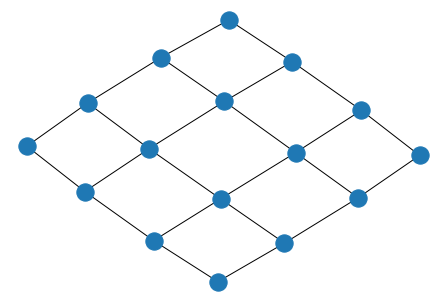

In [2]:
G = nx.grid_graph([4, 4])
nx.draw(G)

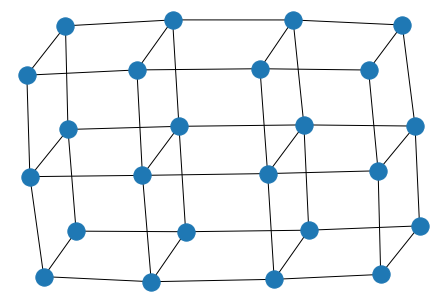

In [11]:
G = nx.grid_graph([2, 3, 4])
nx.draw(G)

Давайте определим матрицу смежности для регулярной сети, соответствующей растровому изображению размера  в примере с MNIST. Для этого этого воспользуемся стандартными приемами из numpy:

In [28]:
import numpy as np
from scipy.spatial.distance import cdist
img_size = 28  # MNIST image width and height
col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
dist = cdist(coord, coord)  # рис. 6 (левое изображение)
sigma = 0.2 * np.pi  # width of a Gaussian
A = np.exp(-dist ** 2 / sigma ** 2) # рис.6 (изображение в центре)

In [29]:
dist.shape

(784, 784)

In [31]:
A.shape

(784, 784)

Можно написать достаточно простой код на основе операторов PyTorch, чтобы увидеть разницу в реализации обычного полносвязного слоя и полносвязного слоя с графовой сверткой:

In [32]:
import torch
import torch.nn as nn

C = 2  # Input feature dimensionality
F = 8  # Output feature dimensionality
W = nn.Linear(in_features=C, out_features=F)  # Trainable weights

# Fully connected layer
X = torch.randn(1, C)  # Input features
Z = W(X)  # Output features : torch.Size([1, 8])

#Graph Neural Network layer
N = 6  # Number of nodes in a graph
X = torch.randn(N, C)  # Input feature
A = torch.rand(N, N)  # Adjacency matrix (edges of a graph)
Z = W(torch.mm(A, X))  # Output features: torch.Size([6, 8])

In [33]:
Z.shape

torch.Size([6, 8])

In [34]:
import imageio  # to save GIFs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
import cv2  # optional (for resizing the filter to look better)

img_size = 28
# Create/load some adjacency matrix A (for example, based on coordinates)
col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
dist = cdist(coord, coord)  # distances between all pairs of pixels
sigma = 0.2 * np.pi  # width of a Gaussian (can be a hyperparameter when training a model)

A = np.exp(- dist / sigma ** 2)  # adjacency matrix of spatial similarity
# above, dist should have been squared to make it a Gaussian (forgot to do that)

scale = 4
img_list = []
cmap = mpl.cm.get_cmap('viridis')
for i in np.arange(0, img_size, 4):  # for every row with step 4
    for j in np.arange(0, img_size, 4):  # for every col with step 4
        k = i*img_size + j
        img = A[k, :].reshape(img_size, img_size)
        img = (img - img.min()) / (img.max() - img.min())
        img = cmap(img)
        img[i, j] = np.array([1., 0, 0, 0])  # add the red dot
        img = cv2.resize(img, (img_size*scale, img_size*scale))
        img_list.append((img * 255).astype(np.uint8))
imageio.mimsave('filter.gif', img_list, format='GIF', duration=0.2)